This script was written by Richie to investigate the male-female ratio of subscribers broken down by age and country

In [5]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
#Set environment variable. 
#Note: CHANGE THIS TO WHERE ON YOUR COMPUTER THE JSON FILE IS
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='G:\My Drive\data science\DataDives\\viamo_api_key.json'

Bigquery_client = bigquery.Client()

In [22]:
demog_data = pd.read_gbq('''select organization_country, age, gender, count(distinct(subscriber_id)) as n_subs
    FROM `viamo-datakind.datadive.321_sessions_1122`  
    GROUP BY organization_country, age, gender''')
print(demog_data.shape)
print(demog_data.describe().round(3))

(60, 4)
            n_subs
count       60.000
mean    127673.450
std     359770.047
min         16.000
25%        927.750
50%      18415.000
75%      82555.500
max    1928756.000


In [23]:
demog_data.head(20)

,organization_country,age,gender,n_subs
0,Uganda,25_34,male,89301
1,Uganda,over_44,male,19171
2,Nigeria,25_34,female,32328
3,Mali,18_24,female,80307
4,Mali,over_44,male,73844
5,Nigeria,35_44,other,970
6,Mali,under_18,None,782
7,Uganda,35_44,female,11896
8,Mali,under_18,male,182292
9,Nigeria,18_24,male,224484


In [25]:
#demog_data.loc[demog_data.gender.isna(),:]
demog_data = demog_data\
    .loc[~demog_data.gender.isin(['other']),:]\
    .dropna()\
    .sort_values(['organization_country', 'age','gender'])

In [38]:
males = demog_data.loc[demog_data.gender == 'male',:].drop(columns = 'gender').rename(columns = {'n_subs':'male_subs'})
females = demog_data.loc[demog_data.gender == 'female',:].drop(columns = 'gender').rename(columns = {'n_subs':'female_subs'})

demog_data_wide = males.merge(females, how='outer',on=['organization_country','age'])
demog_data_wide.loc[:,'male_female_ratio'] = (demog_data_wide.loc[:,'male_subs']/demog_data_wide.loc[:,'female_subs']).round(2)

In [101]:
demog_data_wide.loc[:,'age_int'] = demog_data_wide.loc[:,'age']
demog_data_wide.loc[:,'age_int'].replace(['under_18', '18_24','25_34','35_44','over_44'], [16,21,30,40,45], inplace=True)
demog_data_wide.loc[:,'age_int']=demog_data_wide.loc[:,'age_int'].astype(int)

demog_data_wide.loc[:,'age_reordered'] = demog_data_wide.loc[:,'age']\
    .replace(['under_18', '18_24','25_34','35_44','over_44'], ['1. Under 18', '2. 18-24','3. 25-34','4. 35-44','5. Over 44'], inplace=False)


In [102]:
demog_data_wide.sort_values('age_reordered',inplace=True)

In [103]:
by_country = demog_data_wide.groupby('organization_country').sum()
(by_country.loc[:,'male_subs']/by_country.loc[:,'female_subs']).round(2)

organization_country
Mali       3.73
Nigeria    1.87
Uganda     1.69
dtype: Float64

In [105]:
by_country = demog_data_wide.groupby('age_reordered').sum()
(by_country.loc[:,'male_subs']/by_country.loc[:,'female_subs']).round(2)

age_reordered
1. Under 18    1.34
2. 18-24       2.19
3. 25-34       3.94
4. 35-44       4.55
5. Over 44     3.92
dtype: Float64

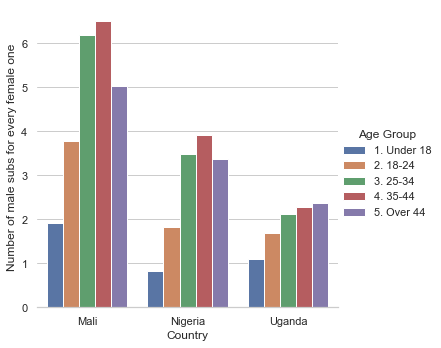

In [110]:

sns.set_theme(style="whitegrid")
g = sns.catplot(data = demog_data_wide, kind = 'bar', x = 'organization_country', y = 'male_female_ratio', hue = 'age_reordered')
g.legend.set_title('Age Group')
g.set_axis_labels('Country', 'Number of male subs for every female one')
g.despine(left = True)